# Case

# Formål 
Sensor data analyse og en løsning som kan redusere risikoen for at nedrivning av kontaktledning skjer. 
# Planen
1. Samle alle json data.
2. Dataforbehandling (data pre-prosessing).
3. Forskning på modeller som passer for data. 
4. Trener og tester modeller.
5. Evaluering av modeller.

In [59]:
# importerer nødvendige biblioteker.

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline


StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 71, Finished, Available)

# 1. Samle alle json data.

In [60]:
# samle alle data 
sdf = spark.read.json("wasbs://azureml-blobstore-3d53d74d-ad80-45bf-9413-92393f9c3b6f@sensor0552536296.blob.core.windows.net/*.json")
sdf = sdf.select("timestamp","event_id","train_id","incident","kontaktkraft","hastighet","location_type","wind_speed","wind_direction","distance_to_pole")
sdf.show()


StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 72, Finished, Available)

+--------------------+--------------------+--------+--------+------------------+------------------+--------------+------------------+--------------+------------------+
|           timestamp|            event_id|train_id|incident|      kontaktkraft|         hastighet| location_type|        wind_speed|wind_direction|  distance_to_pole|
+--------------------+--------------------+--------+--------+------------------+------------------+--------------+------------------+--------------+------------------+
|2023-06-28T12:16:...|03e41ff8-1569-4e5...|       4|       0|53.075336298901874|100.52045817069519|open_landscape|13.654069202674856|         270.0|21.368012904994544|
|2023-06-28T12:15:...|0552ec24-65a9-443...|       4|       0|54.436218020050305|100.84488510632364|open_landscape|13.546852930754524|         270.0|11.103093617000004|
|2023-06-28T12:17:...|06295cca-0f51-4f6...|       6|       0|51.590510084739215|100.81307146667811|open_landscape|13.988899016902758|         180.0|23.290145404

# 2. Dataforbehandling

In [61]:
# endrer dato format
df=sdf.toPandas()
df["timestamp"] = pd.to_datetime(df["timestamp"], format='%Y-%m-%dT%H:%M:%S.%f')


StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 73, Finished, Available)

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 74, Finished, Available)

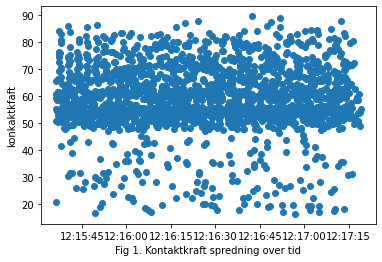

In [62]:
# viser data og prøver å finne ut forhold innimellom de dataene. 
x = df[["timestamp"]]
y = df["kontaktkraft"]
plt.scatter(x,y)
plt.xlabel("Fig 1. Kontaktkraft spredning over tid")
plt.ylabel("konkaktkfaft")
plt.show()

In [63]:
# Definere en funksjon til å map location_type til location_type1
def map_location_type(location):
    mapping = {
        'bridge': 1,
        'mountain': 2,  
        'open_landscape': 3,
        'town': 4
    }
    return mapping.get(location, None)  # Returnere None hvis location ikke er i mapping.


df['location_type1'] = df['location_type'].apply(map_location_type)


StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 75, Finished, Available)

In [64]:
print(df)

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 76, Finished, Available)

                      timestamp                              event_id  \
0    2023-06-28 12:16:29.875945  03e41ff8-1569-4e59-a7d4-779d7156f654   
1    2023-06-28 12:15:45.877945  0552ec24-65a9-4437-96b5-d7ac2ae0f5d4   
2    2023-06-28 12:17:05.262846  06295cca-0f51-4f69-ace2-a066086be93c   
3    2023-06-28 12:15:59.247846  2ffa9da2-449c-47b7-9624-c83cba7667fb   
4    2023-06-28 12:17:12.551945  317320c7-ebc2-48a9-8933-17b45046289d   
...                         ...                                   ...   
1995 2023-06-28 12:17:12.888862  a556eac3-7f14-4e4a-9fd8-b8de67b170eb   
1996 2023-06-28 12:15:52.376862  dd9ea3b5-c7a4-4b4b-b411-ef6445b83e90   
1997 2023-06-28 12:16:37.056848  e7c896d1-812f-4638-97b3-00bef0edb38b   
1998 2023-06-28 12:16:30.306848  fecceb74-b571-45eb-a27e-bad5dd69ac80   
1999 2023-06-28 12:16:40.860848  fccb8112-deec-45ea-afd9-bd48f5a03c52   

      train_id  incident  kontaktkraft   hastighet   location_type  \
0            4         0     53.075336  100.520458  o

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 77, Finished, Available)

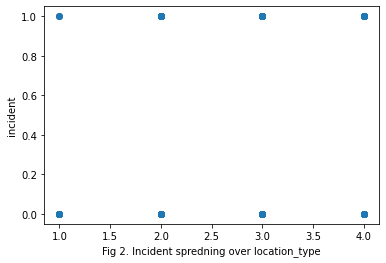

In [65]:
x = df[["location_type1"]]
y = df["incident"]
plt.scatter(x,y)
plt.xlabel("Fig 2. Incident spredning over location_type")
plt.ylabel("incident")
plt.show()

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 78, Finished, Available)

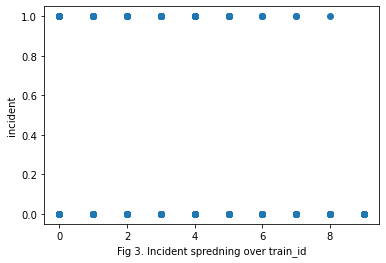

In [66]:
x = df[["train_id"]]
y = df["incident"]
plt.scatter(x,y)
plt.xlabel("Fig 3. Incident spredning over train_id")
plt.ylabel("incident")
plt.show()

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 79, Finished, Available)

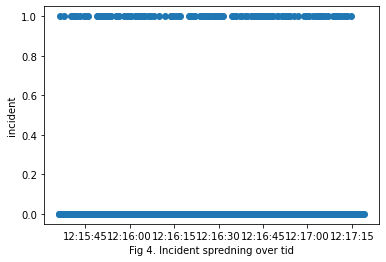

In [67]:
x = df[["timestamp"]]
y = df["incident"]
plt.scatter(x,y)
plt.xlabel("Fig 4. Incident spredning over tid")
plt.ylabel("incident")
plt.show()

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 80, Finished, Available)

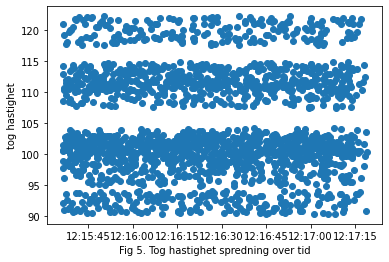

In [68]:
x = df[["timestamp"]]
y = df["hastighet"]
plt.scatter(x,y)
plt.xlabel("Fig 5. Tog hastighet spredning over tid")
plt.ylabel("tog hastighet")
plt.show()

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 81, Finished, Available)

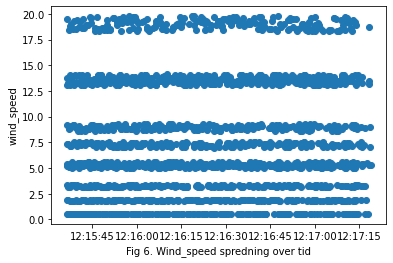

In [69]:
x = df[["timestamp"]]
y = df["wind_speed"]
plt.scatter(x,y)
plt.xlabel("Fig 6. Wind_speed spredning over tid")
plt.ylabel("wind_speed")
plt.show()

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 82, Finished, Available)

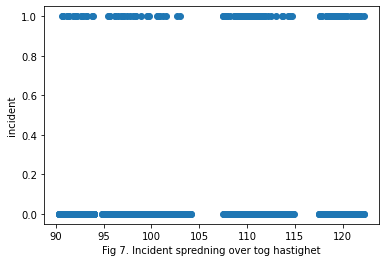

In [70]:
x = df[["hastighet"]]
y = df["incident"]
plt.scatter(x,y)
plt.xlabel("Fig 7. Incident spredning over tog hastighet")
plt.ylabel("incident")
plt.show()

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 83, Finished, Available)

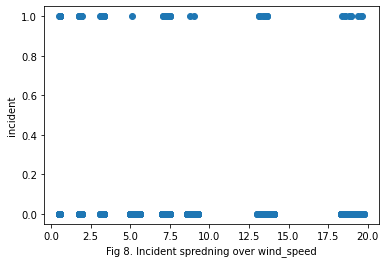

In [71]:
x = df[["wind_speed"]]
y = df["incident"]
plt.scatter(x,y)
plt.xlabel("Fig 8. Incident spredning over wind_speed")
plt.ylabel("incident")
plt.show()

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 84, Finished, Available)

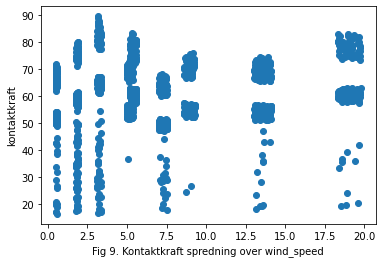

In [72]:
x = df[["wind_speed"]]
y = df["kontaktkraft"]
plt.scatter(x,y)
plt.xlabel("Fig 9. Kontaktkraft spredning over wind_speed")
plt.ylabel("kontaktkraft")
plt.show()

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 85, Finished, Available)

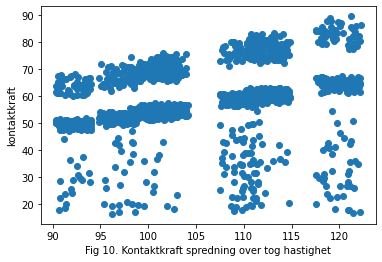

In [73]:
x = df[["hastighet"]]
y = df["kontaktkraft"]
plt.scatter(x,y)
plt.xlabel("Fig 10. Kontaktkraft spredning over tog hastighet")
plt.ylabel("kontaktkraft")
plt.show()

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 86, Finished, Available)

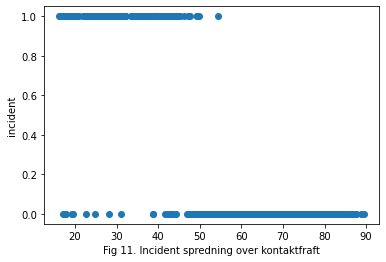

In [74]:
x = df[["kontaktkraft"]]
y = df["incident"]
plt.scatter(x,y)
plt.xlabel("Fig 11. Incident spredning over kontaktfraft")
plt.ylabel("incident")
plt.show()

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 87, Finished, Available)

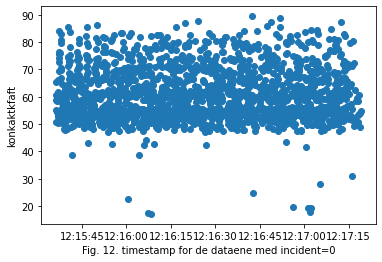

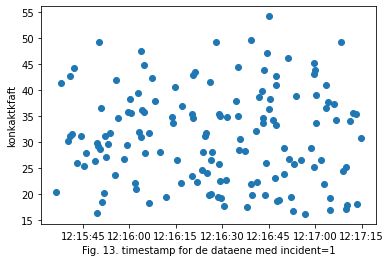

In [75]:
# Vi splitter data inntil to gruppe: en gruppe for data med incident = 0, en annen gruppe med incident =1.

df1, df2 = df.loc[df['incident'] == 0],df.loc[df['incident'] == 1 ]

xfilt1 = df1[["timestamp"]]
yfilt1 = df1["kontaktkraft"]


plt.scatter(xfilt1,yfilt1)
plt.xlabel("Fig. 12. timestamp for de dataene med incident=0")
plt.ylabel("konkaktkfaft")
plt.show()

xfilt2= df2["timestamp"]
yfilt2= df2["kontaktkraft"]


plt.scatter(xfilt2,yfilt2)
plt.xlabel("Fig. 13. timestamp for de dataene med incident=1")
plt.ylabel("konkaktkfaft")
plt.show()

# 3. Forskning på modeller logistiskregresjon, randomforest, gradientboosting. Disse tre klassifiseringsmodeller passer for denne data analyse.
Logistisk regresjon er best for enkle, binære klassifiseringsproblemer med lineære beslutningsgrenser, og når enkelhet og tolkbarhet er prioritert.

Random Forest og Gradient Boosting er mer egnet for komplekse klassifiseringsproblemer hvor forholdet mellom funksjonene ikke nødvendigvis er lineært.

Random Forest er mer robust mot overtilpasning og krever mindre tuning, mens Gradient Boosting ofte gir høyere presisjon, men er mer utsatt for overtilpasning og krever nøye hyperparameter tuning.

# 4. Trener og tester modeller.

In [76]:
# enkel logistiskregresjion

def kontaktkraft_incident_logistiskregresjon():

    x = df[["kontaktkraft"]]
    y = df["incident"]
    
    #forberedelse av data

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=97)
    
    # Initialiserer og trener en logistisk regresjonsmodell
    model = LogisticRegression()
    model.fit(x_train, y_train)

    # Gjør prediksjoner på testsettet
    y_pred = model.predict(x_test)

    # Evaluerer modellens prestasjon
    print(f"Accuracy of simple logistic regression: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))   

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 88, Finished, Available)

In [77]:
# enkel randomforest
def kontaktkraft_incident_randomforest():
    x = df[["kontaktkraft"]]
    y = df["incident"]
    
    #forberedelse av data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=97)
    
    # Initialiserer og trener en logistisk regresjonsmodell
    clf = RandomForestClassifier(n_estimators=100, random_state=57)
    clf.fit(x_train, y_train)
    # Gjør prediksjoner på testsettet
    y_pred = clf.predict(x_test)

    # Evaluerer modellens prestasjon
    print(f"Accuracy of simple random forest: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 89, Finished, Available)

In [78]:
from sklearn.naive_bayes import GaussianNB

# enkel naive bayes
def kontaktkraft_incident_naivebayes():
    x = df[["kontaktkraft"]]
    y = df["incident"]
    
    #forberedelse av data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=97)
    
    # Initialiserer og trener en naive_bayes modell
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    # Gjør prediksjoner på testsettet
    y_pred = gnb.predict(x_test)

    # Evaluerer modellens prestasjon
    print(f"Accuracy of simple naive Bayes: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 90, Finished, Available)

In [79]:
from sklearn.neighbors import KNeighborsClassifier

# enkel K-nearest neighbor
def kontaktkraft_incident_KNN():
    x = df[["kontaktkraft"]]
    y = df["incident"]
    
    #forberedelse av data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=97)
    
    # Initialiserer og trener en KNN modell
    knn = KNeighborsClassifier()
    knn.fit(x_train, y_train)
    
    # Gjør prediksjoner på testsettet
    y_pred = knn.predict(x_test)

    # Evaluerer modellens prestasjon
    print(f"Accuracy of simple KNN: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 91, Finished, Available)

In [80]:
from sklearn.svm import SVC

def kontaktkraft_incident_svm():
    x = df[["kontaktkraft"]]
    y = df["incident"]
    
    #forberedelse av data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=97)
    
    # Initialiserer og trener en enkel support vector machine modell
    svc = SVC()
    svc.fit(x_train, y_train)
    
    # Gjør prediksjoner på testsettet
    y_pred = svc.predict(x_test)

    # Evaluerer modellens prestasjon
    print(f"Accuracy of simple support vector machine: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 92, Finished, Available)

In [81]:
# enkel gradientboosting
def kontaktkraft_incident_gradientboosting():
    x = df[["kontaktkraft"]]
    y = df["incident"]
    
    #forberedelse av data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=97)
    
    # Initialiserer og trener en gradient boosting modell
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=97)
    gbc.fit(x_train, y_train)
    
    # Gjør prediksjoner på testsettet
    y_pred = gbc.predict(x_test)

    # Evaluerer modellens prestasjon
    print(f"Accuracy of simple gradient boosting: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 93, Finished, Available)

In [82]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns_to_normalize = ["kontaktkraft","hastighet","wind_speed","wind_direction","distance_to_pole"]
# Applying Z-score Normalization only to specified columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

print(df)

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 94, Finished, Available)

                      timestamp                              event_id  \
0    2023-06-28 12:16:29.875945  03e41ff8-1569-4e59-a7d4-779d7156f654   
1    2023-06-28 12:15:45.877945  0552ec24-65a9-4437-96b5-d7ac2ae0f5d4   
2    2023-06-28 12:17:05.262846  06295cca-0f51-4f69-ace2-a066086be93c   
3    2023-06-28 12:15:59.247846  2ffa9da2-449c-47b7-9624-c83cba7667fb   
4    2023-06-28 12:17:12.551945  317320c7-ebc2-48a9-8933-17b45046289d   
...                         ...                                   ...   
1995 2023-06-28 12:17:12.888862  a556eac3-7f14-4e4a-9fd8-b8de67b170eb   
1996 2023-06-28 12:15:52.376862  dd9ea3b5-c7a4-4b4b-b411-ef6445b83e90   
1997 2023-06-28 12:16:37.056848  e7c896d1-812f-4638-97b3-00bef0edb38b   
1998 2023-06-28 12:16:30.306848  fecceb74-b571-45eb-a27e-bad5dd69ac80   
1999 2023-06-28 12:16:40.860848  fccb8112-deec-45ea-afd9-bd48f5a03c52   

      train_id  incident  kontaktkraft  hastighet   location_type  wind_speed  \
0            4         0     -0.457967  -0

In [83]:
# multippel logistikkregresjion
def kontaktkraft_incident_logistiskregresjon2():

    x = df[["kontaktkraft","wind_speed","hastighet","wind_direction" ,"distance_to_pole"]]
    y = df["incident"]
    
    #forberedelse av data

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=97)
    
    # Initialiserer og trener en logistisk regresjonsmodell
    model = LogisticRegression()
    model.fit(x_train, y_train)

    # Gjør prediksjoner på testsettet
    y_pred = model.predict(x_test)

    # Evaluerer modellens prestasjon
    print(f"Accuracy of multiple logistic regression: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 95, Finished, Available)

In [84]:
# multippel random forest
def kontaktkraft_incident_randomforest2():
    x = df[["kontaktkraft","wind_speed","hastighet","wind_direction","distance_to_pole"]]
    y = df["incident"]
    
    #forberedelse av data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=97)
    
    # Initialiserer og trener en logistisk regresjonsmodell
    clf = RandomForestClassifier(n_estimators=100, random_state=57)
    clf.fit(x_train, y_train)
    # Gjør prediksjoner på testsettet
    y_pred = clf.predict(x_test)

    # Evaluerer modellens prestasjon
    print(f"Accuracy of multiple random forest: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 96, Finished, Available)

In [85]:
# multippel naive bayes
def kontaktkraft_incident_naivebayes2():
    x = df[["kontaktkraft","wind_speed","hastighet","wind_direction","train_id"]]
    y = df["incident"]
    
    #forberedelse av data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=97)
    
    # Initialiserer og trener en naive_bayes modell
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    # Gjør prediksjoner på testsettet
    y_pred = gnb.predict(x_test)

    # Evaluerer modellens prestasjon
    print(f"Accuracy of multiple naive Bayes: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 97, Finished, Available)

In [86]:
# multippel K-nearest neighbor
def kontaktkraft_incident_KNN2():
    x = df[["kontaktkraft","wind_speed","hastighet","wind_direction","train_id"]]
    y = df["incident"]
    
    #forberedelse av data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=97)
    
    # Initialiserer og trener en KNN modell
    knn = KNeighborsClassifier()
    knn.fit(x_train, y_train)
    
    # Gjør prediksjoner på testsettet
    y_pred = knn.predict(x_test)

    # Evaluerer modellens prestasjon
    print(f"Accuracy of multiple KNN: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 98, Finished, Available)

In [87]:
def kontaktkraft_incident_svm2():
    x = df[["kontaktkraft","wind_speed","hastighet","wind_direction"]]
    y = df["incident"]
    
    #forberedelse av data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=97)
    
    # Initialiserer og trener en enkel support vector machine modell
    svc = SVC()
    svc.fit(x_train, y_train)
    
    # Gjør prediksjoner på testsettet
    y_pred = svc.predict(x_test)

    # Evaluerer modellens prestasjon
    print(f"Accuracy of multiple support vector machine: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 99, Finished, Available)

In [88]:
# multippel gradientboosting
def kontaktkraft_incident_gradientboosting2():
    x = df[["kontaktkraft","wind_speed","hastighet","wind_direction"]]
    y = df["incident"]
    
    #forberedelse av data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=97)
    
    # Initialiserer og trener en gradient boosting modell
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=97)
    gbc.fit(x_train, y_train)
    
    # Gjør prediksjoner på testsettet
    y_pred = gbc.predict(x_test)

    # Evaluerer modellens prestasjon
    print(f"Accuracy of multiple gradient boosting: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 100, Finished, Available)

In [45]:
if __name__ == "__main__":
    kontaktkraft_incident_logistiskregresjon()
    kontaktkraft_incident_randomforest()
    kontaktkraft_incident_naivebayes()
    kontaktkraft_incident_KNN()
    kontaktkraft_incident_svm()
    kontaktkraft_incident_gradientboosting()
    kontaktkraft_incident_logistiskregresjon2()
    kontaktkraft_incident_randomforest2()
    kontaktkraft_incident_naivebayes2()
    kontaktkraft_incident_KNN2()
    kontaktkraft_incident_svm2()
    kontaktkraft_incident_gradientboosting2()

StatementMeta(cd8c8f88-1104-4cc8-b9ee-c7507007e049, 10, 57, Finished, Available)

Accuracy of simple logistic regression: 0.9716666666666667
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       559
           1       0.83      0.73      0.78        41

    accuracy                           0.97       600
   macro avg       0.91      0.86      0.88       600
weighted avg       0.97      0.97      0.97       600

[[553   6]
 [ 11  30]]
Accuracy of simple random forest: 0.975
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       559
           1       0.81      0.83      0.82        41

    accuracy                           0.97       600
   macro avg       0.90      0.91      0.90       600
weighted avg       0.98      0.97      0.98       600

[[551   8]
 [  7  34]]
Accuracy of simple naive Bayes: 0.9716666666666667
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       559
           1       0.88      0.68      0.

# 5. Evaluering av modeller.
Incident er bare avhengig av kontaktkraft. Andre faktorer som tog hastighet, wind_speed, wind_direction pavirker ikke incident. 
Det viser at logistikkregresjon, randomforest, naive bayes, K-nearest neighbor, support vector machine passer bedre for analyse med nøyaktighet 97.3%, 97.5%, 97.2%, 97.8%, 98% enn gradientboosting med 93.5%.